<a href="https://colab.research.google.com/github/phoenixfin/deeplearning-notebooks/blob/main/Passager_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
series = []
with open('/content/data.txt') as f:
  for line in f.readlines()[1:]:
    series.append(int(line[12:]))    
    # series.append(int(line.split('\t')[1]))
df = pd.DataFrame({'num_passager': series})
df

,num_passager
0,1226800
1,926891
2,782725
3,1023038
4,1126293
5,692565
6,1165880
7,1207156
8,1129954
9,745100


In [ ]:
mean = df.mean()
std = df.std()

# mengisi data kosong dengan rata-rata dari data
df.fillna(df.mean(), inplace=True)

# normalisasi data sehingga memiliki rata-rata di 0 dan variansi 1
df = (df - mean)/(std + 0.000001)

# kompres data sehingga hanya berada pada rentang 0 - 5
dmax = float(df.max())
dmin = float(df.min())
drange = dmax - dmin
scaled_range = 1.
df = ((df - dmin)/drange) * scaled_range

# lihat sekilas hasilnya
df.head()

,num_passager
0,0.753457
1,0.437865
2,0.286160
3,0.539040
4,0.647694


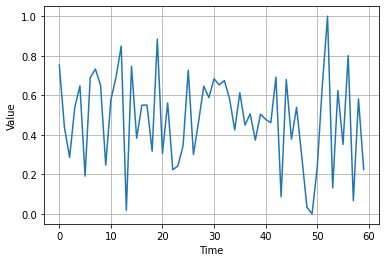

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

plot_series(range(60), np.array(df))

Selanjutnya, kita akan konversi data array tersebut menjadi tensorflow Dataset dengan batch yang disesuaikan 
berdasarkan lebar jendela training yang akan dilakukan.

In [ ]:
import tensorflow as tf

window_size = 10

def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
train_set = sequential_window_dataset(df['num_passager'], window_size)


## Membangun Model

Model yang akan dibangun adalah model Sequential berupa RNN yang stateful dengan sel LSTM.

Optimizer yang digunakan adalah Stochastic Gradient Descent dengan momentum.

In [ ]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                            input_shape=[None]),
        tf.keras.layers.SimpleRNN(100, return_sequences=True),
        tf.keras.layers.SimpleRNN(100),
        tf.keras.layers.Dense(1)
        # tf.keras.layers.Lambda(lambda x: x * 200.0)
    ])

    model.compile(
        loss = tf.keras.losses.Huber(),
        optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9),
        metrics = ["mae"]
    )

    return model

Selanjutnya, didefinisikan juga beberapa callbacks yang akan digunakan.

In [ ]:
def set_callbacks(model):
    callbacks = []
    CB = tf.keras.callbacks

    # no progress stopping callback
    impatient = CB.EarlyStopping(
        monitor = 'mae',
        patience = 10)
    # callbacks.append(impatient)

    # stop when enough callback
    def stopper(epoch, logs):
        if logs['mae'] < 0.1: 
            model.stop_training = True
    good_res = CB.LambdaCallback(on_epoch_end=lambda e,l: stopper(e,l))
    callbacks.append(good_res)

    # reset state of the model every epoch (because it will be a stateful rnn)                        
    reset_state = CB.LambdaCallback(on_epoch_begin=lambda e,l: model.reset_states())

    return callbacks

## Melatih Model!

Sekarang, saatnya membungkus semuanya

In [ ]:
model = build_model()

model.fit(
    train_set, 
    epochs = 200,
    callbacks = set_callbacks(model)
)

Epoch 1/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0425 - mae: 0.2423
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0425 - mae: 0.2423
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0425 - mae: 0.2423
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0425 - mae: 0.2422
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0425 - mae: 0.2422
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0425 - mae: 0.2422
Epoch 7/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0425 - mae: 0.2421
Epoch 8/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0425 - mae: 0.2421
Epoch 9/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0424 - mae: 0.2421
Epoch 10/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0424 - mae: 0.2420
Epoch 11/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0424 

Wow! Dalam 2 epoch MAE langsung mencapai batas kesuksesan yang ditetapkan (10 persen dari skala data).

Berati model kita sudah sangat bagus.

Sekarang saatnya kita cek hasilnya

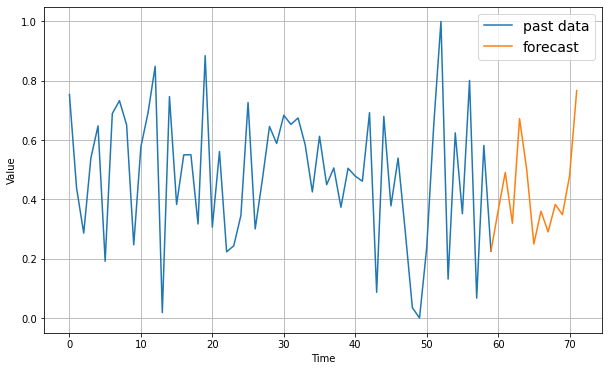

In [ ]:
def predict(time_num, series):
    for time in range(time_num):
        ds = tf.data.Dataset.from_tensor_slices(series[-window_size:])
        ds = ds.window(window_size, shift=1, drop_remainder=True)
        ds = ds.flat_map(lambda w: w.batch(window_size))
        ds = ds.batch(32).prefetch(1)
        forecast = model.predict(ds)[0][0]
        series.append(forecast)
    return series[-time_num-1:]

time_num = 12 #number of months to be forecasted
prediction = predict(time_num, list(df['num_passager']))

plt.figure(figsize=(10, 6))
plot_series(range(60), df['num_passager'], label="past data")
plot_series(range(59, 60+time_num), prediction, label="forecast")